# Gradient boosting

## Learning objectives
- Understand
    - gradient boosting algorithms
- implement gradient boosting

## Intro - Feedback loops
In the real world, lots of classical control systems depend on feedback loops. 
Feedback loops work by repeatedly taking a measurement, and then taking an action to push the value measured towards the desired value. 
Gradient boosting kind of implements this for machine learning models by having a sequence of models whose outputs are added together, where the next model is trained to correct the error of the one before.

## Gradient boosting

Gradient boosting is another ensemble method, like bagging and boosting which we looked at previously. It is almost always implemented using decision trees as the models. Like boosting, the point of making an ensemble via gradient boosting is to increase the capacity of the overall model, rather than to regularise it like in bagging.

We will start off by looking at gradient boosting for regression.
For this, we will need a dataset with continuous features, and a differentiable loss function.

Similarly to boosting, gradient boosting:
- produces a sequence of models who's predictions are added together to make a final prediction
- is almost always done with decistion trees as models

Differently to regular boosting, for gradient boosting:
- the models built **predict the (pseudo-)residual between the previous model's prediction and the ideal output** (more on this soon)
- the models' predictions are all combined with an equal weight, which is called the learning rate (remember this? we'll discuss the relationship to gradient descent shortly), except for the base (first) model whose prediction is not weighted
- all models are trained on the entire original dataset, rather than on a dataset bootstrapped from it
- the decision trees which gradient boosting builds may be larger than stumps (decision trees with ```max_depth=1```)

![](images/gradient_boosting_summary.jpg)


### The prediction from the base (first) model

Gradient boosting starts by outputting a single prediction for all examples, that is, by predicting the same constant value, $c$, for all of them.

## $$h_0(x) = c$$

But what is the best value of $c$, which we will call $c^*$? 
Let's find what value of $c$ would minimise our mean squared error objective to answer this.

![](images/best_constant.jpg)

We've found that the constant that is predicted as the label for every example which minimises the mean squared error is the mean of the labels in the dataset.

### The predictions from the following sequence of models

Gradient boosting then sequentially adds to the total hypothesis by making trees that correct for the error made so far and adding those predictions scaled by a learning rate $\alpha$.

![](images/gradient_boosting_hypothesis.jpg)

To correct for the error made by the sequence so far, each successive tree predicts a value that when added to the hypothesis, would reduce the loss for that example.

The adjustment needed to be made for each example depends on the error resulting from the latest prediction. 
If the error is positive, then our estimate is too high, and we need to push it in the negative direction.
And vice versa.

### This sounds a bit like gradient descent right?
In fact, it is implemented in almost the same way. 
We take the derivative of the loss with respect to the prediction of the sequence so far, and shift that prediction in that direction, proportionally to that value.

This is where the name gradient boosting comes from: each sequential model boosts the predictions of the previous one by adjusting it's prediction in a direction that reduces the error, by following the gradient of the loss with respect to the most recent prediction downhill.

The difference between gradient descent for optimisation and gradient boosting is that this shifting process does not update the model parameters, but updates the prediction, and it is not done whilst training, but is done whilst making predictions.
Gradient descent is an optimisation algorithm, whereas gradient boosting is a model.

The derivative tells us which direction to move our prediction to **increase** the error, which is obviously the opposite direction that we want to adjust it.
So as with gradient descent, we move in the direction of the negative gradient, rather than the positive.
We also scale the update by the same kind of learning rate that we have seen before in gradient descent.
It is a value between zero and 1.

Only during training do we have access to the ground truth labels for each example, which is required to compute the gradient. 
So we have to train the trees to predict the gradients which will be used to update the predictions.

When we evaluate the half square loss function for a particular example, it's derivative gives us the error exactly. 
The negative of this error is what more needs to be added to the prediction for it to reach the true label - we call this **the residual**.

![](images/residual.jpg)

When using other loss functions, such as the MSE loss for simplicity, or the cross entropy loss for classification, the derivative which gives us the update to make to the predictions is not equal to the residual.
In this case, we call the update quantities **pseudo residuals**.

**Each successive tree in the sequence is fit to predict this pseudo-residual (the gradient)!** 

In general, the pseudo-residual is given by:
## $r_{il} = - [\frac{\partial L(H(x_i), y_i)}{\partial H(x_i)}]_{H(x)=H_{l-1}(x)}$ 

Here's how gradient boosting pushes the predictions closer to the label, in the same way that gradient descent does.

![](images/gradient_boosting_vs_gradient_descent.jpg)

## Hyperparameters
- size of trees: specify the maximum depth of the tree of the maximum number of leaves
- number of models in sequence

Algorithm overview
- build a base predictor that predicts the final label for all exmaples in the dataset to be equal to the mean of the labels of the dataset
- for as many models as you want in your gradient boosting sequence
    - for each example in the dataset, set the new target equal to the pseudo-residual of the predictions made by the combination of the preceding models
    - train a model to predict this error and add it to the sequence of gradient boosting models

In [ ]:
# Run this cell to download the necessary package to run the next cells
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/get_colors.py" "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/utils.py"

(20, 1) (20, 1)


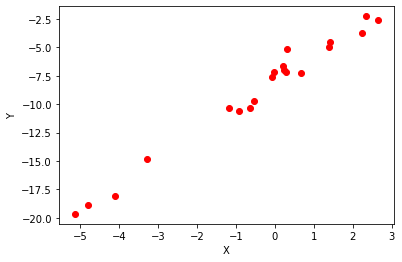

In [2]:
from utils import get_regression_data, show_regression_data, visualise_regression_predictions

X, Y = get_regression_data()
show_regression_data(X, Y)

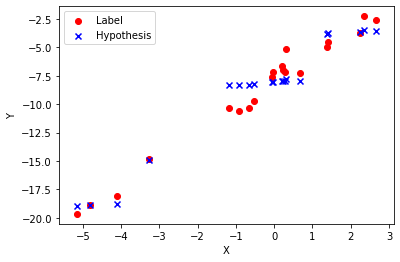

16.47059166473123

In [9]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import json

class GradientBoostedDecisionTree:
    def __init__(self, n_trees=10, learning_rate=0.1):
        self.n_trees = n_trees
        self.learning_rate = learning_rate

    def calc_loss(self, predictions, labels):
        return 0.5 * np.sum((predictions - labels)**2)

    def calc_loss_gradient(self, predictions, labels):
        # print('labels:', labels.shape)
        # print('predictions:', predictions.shape)
        # print((labels - predictions).shape)
        return labels - predictions # in the case of MSE loss the gradient is equal to the residual

    def fit(self, X, Y):
        labels = Y
        self.trees = []
        losses = []
        for tree_idx in range(self.n_trees):
            # print(f'training tree {tree_idx}')
            tree = DecisionTreeRegressor(max_depth=2)
            tree.fit(X, labels)
            predictions = tree.predict(X)
            predictions = predictions.reshape(-1, 1)
            labels = self.calc_loss_gradient(predictions, labels) # calculate residual
            self.trees.append(tree)
            # print()

    def predict(self, X):
        predictions = np.zeros((len(X), 1))
        for tree_idx, tree in enumerate(self.trees):
            this_prediction = tree.predict(X).reshape(-1, 1)
            if tree_idx == 0:
                predictions += this_prediction
            else:
                predictions += self.learning_rate * tree.predict(X).reshape(-1, 1)
        
        return predictions

    def __repr__(self):
        return json.dumps([{'depth': t.max_depth} for t in self.trees])

gradientBoostedDecisionTree = GradientBoostedDecisionTree()
gradientBoostedDecisionTree.fit(X, Y)
predictions = gradientBoostedDecisionTree.predict(X)
visualise_regression_predictions(X, predictions, Y)
gradientBoostedDecisionTree.calc_loss(predictions, Y)

## Would gradient boosting work for model types other than decision trees?

Refer back to the expression that describes how the predictions of the models in the gradient boosting sequence are combined.
You can see that this is a linear combination of the models. 
If each of the models is a linear model, such as the straight line function that we implemented for linear regression, then the final prediction will be a linear combination of linear combinations of the example features.
Evaluating this, you can see that the final prediction can be expressed as a single linear combination of features... so gradient boosting any linear model is a waste of our time, as it does not increase the capacity of the model.

However, gradient boosting a non-linear model such as polynomial would result in a final prediction expression which could not be simplified in such a way, and hence can increase the capacity of the model, which is the point of ensembling via gradient boosting.

## Challenges
- Watch [this](https://www.youtube.com/watch?v=jxuNLH5dXCs) and the following video to understand the differences that need to be made to implement gradient boosting for classification.
- Implement gradient boosting for a model that is not a decision tree.

##